In [1]:
import pandas as pd
import matplotlib
%matplotlib inline 
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
import operator
from itertools import islice
import string 
from tabulate import tabulate
import json
from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
import os
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
import seaborn as sns

In [2]:
df = pd.read_csv('data/cleaned_records_bibs.csv', delimiter='|')

In [3]:
stop_words_en = list(stopwords.words('english'))
abc = list(string.ascii_lowercase) 
punct_signs = list(string.punctuation)    
stop_words_en = list(stop_words_en) + abc + punct_signs + ["‘","©","since","•", "?", "¿", "/b","“","”","per", "cent", "must", "while","could", "’", "``","''","'s","new", "one", "this", "in",  "--", "us", "re", "also", "first", "br", "nbsp", "..."] 


f = open('../lexicon/spanish_stopwords.txt')
stop_words_spa = [w.strip() for w in f.readlines()]
stop_words_spa = stop_words_spa + stop_words_en + ["«", "años", "nueva", "obra",  "gran", "vez", "»"] 
   

In [4]:
len(df)

8277

In [5]:
def getNGram(text, n, m):
    text = text.lower()
    ngramas = ngrams(text.split(), n)
    h_dict = {}   
    for grams in ngramas:
        words = ' '.join(grams)        
        words = words.lower() 
        if words in h_dict:
            h_dict[words] = h_dict[words] + 1
        else: 
            h_dict[words] = 1 
    sorted_dict = sorted(h_dict.items(), key=operator.itemgetter(1), reverse=True)
    if m is -1:
        return list(sorted_dict)
    else:
        return list(islice(sorted_dict, m))
    
def cleanTextEnglish(text):
    word_tokens = word_tokenize(text.lower())
    filtered_text = []
    for w in word_tokens:
        if w not in stop_words_en:
            filtered_text.append(w)
    return ' '.join(filtered_text)

def cleanTextSpanish(text):
    word_tokens = word_tokenize(text.lower())
    filtered_text = []
    for w in word_tokens:
        if w not in stop_words_spa:
            filtered_text.append(w)
    return ' '.join(filtered_text)



n_top_words = 15
n_features = 10000
n_components = 30
full_topics= {}

def trainNMF(data_samples, stop_words):
    tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1,
                                   max_features=n_features,
                                   stop_words=stop_words)
    tfidf = tfidf_vectorizer.fit_transform(data_samples)

    nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
    
    feature_names = tfidf_vectorizer.get_feature_names()
   
    print_top_words(nmf.components_, feature_names, n_top_words)
    
    return nmf, tfidf_vectorizer
      
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model):
        full_topics[topic_idx] = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print("Topic #%d: " % topic_idx + full_topics[topic_idx] )
        print()

def extractNMFTopics(data, nmf, tfidf_vectorizer):
    text = ['/n'.join(data)]
    tfidf_data = tfidf_vectorizer.transform(text)
    new_nmf = nmf.transform(tfidf_data)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    ts = {}
    for topic_idx, topic in enumerate(new_nmf):
        i = 0
        for freq in topic:
            if freq > 0.22:
                print("Topic #%d: " % i + full_topics[i] + " ( "  + str(round(freq*100, 2)) +  "%)")
                print()             
            i = i + 1
        
        
def extractTopicsbyCat(nmf, tfidf_vectorizer):
    for cat in categories:                         
        for  files in os.walk('data/mesa/topics/'+ cat):     
            if(len(files[2])>0): 
                print(categories[cat],'--', files[0].replace('data/mesa/topics/'+ cat , '') ,'\n')    
                dataset = fetch_files_from(files[0])
                extractNMFTopics(dataset, nmf, tfidf_vectorizer)
                print('-------------------------------------')
                
def fetch_texts_from_corpus(df):
    text_corpus_en = []
    text_corpus_es = []
    for idx, row in df.iterrows():
        if type(row['abstract']) != float:
            if row['lang'] == 'English':
                   text_corpus_en.append(row['abstract'])
            if row['lang'] == 'Spanish':
                   text_corpus_es.append(row['abstract'])
    return text_corpus_en, text_corpus_es

def clean_array_text(text_array, lang):
    result = []
    for t in text_array:
        if lang == 'English':
            result.append(cleanTextEnglish(t))
        if lang == 'Spanish':
             result.append(cleanTextSpanish(t))
    return result

In [6]:
text_corpus_en, text_corpus_es = fetch_texts_from_corpus(df)
cleaned_text_corpus_en = cleanTextEnglish(' '.join(text_corpus_en))
cleaned_text_corpus_es = cleanTextSpanish(' '.join(text_corpus_es))
print(len(cleaned_text_corpus_en), len(cleaned_text_corpus_es))

4486057 252404


## Most popular ngrams in English publications

In [9]:
final = getNGram(cleaned_text_corpus_en, 1, 50)
final2 = getNGram(cleaned_text_corpus_en, 2, 50)
final3 = getNGram(cleaned_text_corpus_en, 3, 50)
final5 = []
for i in range(0,50):
        final5.append(final[i] + final2[i]+ final3[i])
print(tabulate(final5, ['Unigram-English', 'Number', 'Bigram-English', 'Number', 'Trigram-English', 'Number'], tablefmt="presto", numalign="center"))
print('--------------------------------------------------------------------------------------------------------')
print()

 Unigram-English   |  Number  | Bigram-English             |  Number  | Trigram-English                |  Number
-------------------+----------+----------------------------+----------+--------------------------------+----------
 transatlantic     |   5236   | united states              |   1608   | board transatlantic studies    |   346
 american          |   2743   | rights reserved            |   779    | cambridge university press     |   257
 european          |   2675   | european union             |   574    | transatlantic slave trade      |   252
 article           |   2105   | slave trade                |   522    | taylor francis group           |   203
 trade             |   2083   | university press           |   442    | transatlantic trade investment |   176
 states            |   2081   | foreign policy             |   408    | trade investment partnership   |   175
 world             |   1837   | taylor francis             |   403    | press rights reserved          |  

## Most popular ngrams in Spanish

In [10]:
final4 = getNGram(cleaned_text_corpus_es, 1, 50)
final5 = getNGram(cleaned_text_corpus_es, 2, 50)
final6 = getNGram(cleaned_text_corpus_es, 3, 50)
final7 = []
for i in range(0,50):
        final7.append(final4[i] + final5[i] + final6[i])
print(tabulate(final7, ['Unigram-English', 'Number', 'Bigram-English', 'Number', 'Trigram-English', 'Number'], tablefmt="presto", numalign="center"))
print('-------------------------------------------------------------------------------------------------------------')
print()

 Unigram-English   |  Number  | Bigram-English          |  Number  | Trigram-English                  |  Number
-------------------+----------+-------------------------+----------+----------------------------------+----------
 historia          |   146    | estados unidos          |    42    | primera guerra mundial           |    7
 vida              |   111    | siglo xx                |    22    | segunda guerra mundial           |    6
 transatlántico    |   107    | buenos aires            |    20    | turistas hablantes español       |    5
 libro             |    98    | latin american          |    14    | estupenda turistas hablantes     |    5
 mundo             |    94    | guerra mundial          |    13    | fácil estupenda turistas         |    5
 siglo             |    71    | siglo xix               |    11    | español interesados aprender     |    5
 transatlantic     |    70    | low cost                |    11    | español vocabulario lista        |    5
 novela    

## 20 General Topics English

In [11]:
training_data, training_data_spa = fetch_texts_from_corpus(df)
training_data = clean_array_text(text_corpus_en, 'English')
nmf, tfidf_vectorizer = trainNMF(training_data, stop_words_en)

Topic #0: europe european integration union economic china western crisis relationship europeans east countries power global political

Topic #1: american anglo america americans latin culture special board native relationship studies literature exceptionalism nineteenth novel

Topic #2: trade ttip investment partnership negotiations agreement agreements wto economic free tpp mega regional bilateral countries

Topic #3: slave trade slaves atlantic africa africans century americas abolition ports enslaved ships traders 1807 cuba

Topic #4: eu union european member cooperation data ep protection external usa parliament policy agreement policies terrorism

Topic #5: transatlantic history world political article atlantic social century cultural america two international rights within historical

Topic #6: nato alliance military allies afghanistan treaty organization security north defense burden atlantic libya defence forces

Topic #7: policy foreign administration towards uk military arti

## 20 General Topics Spanish

In [12]:
training_data_spa = clean_array_text(text_corpus_es, 'Spanish')
nmfspa, tfidf_vectorizerspa = trainNMF(training_data_spa, stop_words_spa)

Topic #0: historia estados unidos mundo libro guerra titanic siglo hundimiento novela españa época imperio mundial social

Topic #1: intellectual community imagined trips citations methodology late configured rodó bringing took underthe coined homeland relegation

Topic #2: carta generación asombran tardará pilotos escalas ehrlich reportera colum mccann firmada irlanda 1919 encierran abierta

Topic #3: coronado controversy perez avellaneda two responses similar women consider contribute opponents gomez fundamentally viewed feminine

Topic #4: matas vila latest hybridity autofiction metafictional deep intertextuality appreciate reflection originality emphasizes links details defined

Topic #5: español hablantes interesados aprender croata ucraniano islandés ruso italiano estupenda traducidas vocabulario lista turistas fácil

Topic #6: criticism transatlantic arguedas locates collectivities meet variants garcilaso sequential hospitality constructions horizontal ayala corresponds oppositi

## Keywords in last 5 Decades

In [13]:
def extractNGrams(corpus_en, corpus_es):
    corpus_en = cleanTextEnglish(corpus_en)
    corpus_es = cleanTextSpanish(corpus_es)
    
    final1 = getNGram(corpus_en, 1, 10)
    final2 = getNGram(corpus_en, 2, 10)
    final3 = getNGram(corpus_en, 3, 10)
    finalt = []
    for i in range(0,len(final1)):
        finalt.append(final1[i] + final2[i]+ final3[i])
    print(tabulate(finalt, ['Unigram-English', 'Number', 'Bigram-English', 'Number', 'Trigram-English', 'Number'], tablefmt="presto", numalign="center"))
    print('--------------------------------------------------------------------------------------------------------')
    print()

    final4 = getNGram(corpus_es, 1, 10)
    final5 = getNGram(corpus_es, 2, 10)
    final6 = getNGram(corpus_es, 3, 10)
    final7 = []
    for i in range(0,len(final4)):
            final7.append(final4[i] + final5[i] + final6[i])
    print(tabulate(final7, ['Unigram-Spanish', 'Number', 'Bigram-Spanish', 'Number', 'Trigram-Spanish', 'Number'], tablefmt="presto", numalign="center"))
    print('-------------------------------------------------------------------------------------------------------------')
    print()
    return final1, final2, final3, final4, final5, final6

In [14]:
decades = { 
    '1970':{'1spa':[],'2spa': [],'3spa':[],'1en':[],'2en':[],'3en':[]},
    '1980':{'1spa':[],'2spa': [],'3spa':[],'1en':[],'2en':[],'3en':[]},
    '1990':{'1spa':[],'2spa': [],'3spa':[],'1en':[],'2en':[],'3en':[]},
    '2000':{'1spa':[],'2spa': [],'3spa':[],'1en':[],'2en':[],'3en':[]},
    '2010':{'1spa':[],'2spa': [],'3spa':[],'1en':[],'2en':[],'3en':[]}  
}
texts = {
    '1970':{'Spanish':[],'English':[]},
    '1980':{'Spanish':[],'English':[]},
    '1990':{'Spanish':[],'English':[]},
    '2000':{'Spanish':[],'English':[]},
    '2010':{'Spanish':[],'English':[]}
}
for idx, row in df.iterrows():
    if type(row['abstract']) == float:
        continue
    if type(row['lang']) == float:
        print(row)
        break
    if int(row['year']) in range(1970, 1979): 
        texts['1970'][row['lang']].append(row['abstract'])
    elif int(row['year']) in range(1980, 1989): 
        texts['1980'][row['lang']].append(row['abstract'])    
    elif int(row['year']) in range(1990, 1999): 
        texts['1990'][row['lang']].append(row['abstract'])
    elif int(row['year']) in range(2000, 2009): 
        texts['2000'][row['lang']].append(row['abstract'])
    elif int(row['year']) > 2009: 
        texts['2010'][row['lang']].append(row['abstract']) 
    
    
for t in texts.keys():
    print()
    print(t)
    print()
    final1, final2, final3, final4, final5, final6  = extractNGrams(' '.join(texts[t]['English']), ' '.join(texts[t]['Spanish']))
    decades[t]['1spa'] = final4
    decades[t]['2spa'] = final5
    decades[t]['n3spa'] = final6
    decades[t]['1en'] = final1
    decades[t]['2en'] = final2
    decades[t]['3e'] = final3    


2000

 Unigram-English   |  Number  | Bigram-English             |  Number  | Trigram-English            |  Number
-------------------+----------+----------------------------+----------+----------------------------+----------
 transatlantic     |   1064   | united states              |   394    | cambridge university press |    71
 european          |   637    | rights reserved            |   191    | transatlantic slave trade  |    41
 american          |   538    | european union             |   124    | press rights reserved      |    38
 states            |   522    | foreign policy             |   108    | ltd. rights reserved       |    35
 europe            |   475    | slave trade                |    97    | europe united states       |    32
 international     |   443    | university press           |    93    | end cold war               |    30
 united            |   436    | cold war                   |    92    | 2006 palgrave macmillan    |    28
 world             |   3

 Unigram-English   |  Number  | Bigram-English   |  Number  | Trigram-English             |  Number
-------------------+----------+------------------+----------+-----------------------------+----------
 transatlantic     |   121    | united states    |    35    | taylor francis group        |    14
 europe            |    60    | slave trade      |    16    | francis group llc           |    14
 economic          |    47    | heat transport   |    16    | end cold war                |    7
 states            |    47    | taylor francis   |    15    | transatlantic slave trade   |    7
 european          |    45    | rights reserved  |    15    | human resource management   |    6
 atlantic          |    45    | group llc        |    14    | guinea worm disease         |    6
 water             |    42    | francis group    |    14    | atlantic deep water         |    5
 trade             |    42    | north atlantic   |    13    | human resource development  |    5
 two               |

## Keywords by Affiliation 

In [15]:
decades = { 
    'University London':{'1spa':[],'2spa': [],'3spa':[],'1en':[],'2en':[],'3en':[]},
    'Harvard University':{'1spa':[],'2spa': [],'3spa':[],'1en':[],'2en':[],'3en':[]},
    'University of California':{'1spa':[],'2spa': [],'3spa':[],'1en':[],'2en':[],'3en':[]},
    'Johns Hopkins University':{'1spa':[],'2spa': [],'3spa':[],'1en':[],'2en':[],'3en':[]},
    'Georgetown University':{'1spa':[],'2spa': [],'3spa':[],'1en':[],'2en':[],'3en':[]},  
    'University Toronto':{'1spa':[],'2spa': [],'3spa':[],'1en':[],'2en':[],'3en':[]} 
}
texts = {
    'University London':{'Spanish':[],'English':[]},
    'Harvard University':{'Spanish':[],'English':[]},
    'University of California':{'Spanish':[],'English':[]},
    'Johns Hopkins University':{'Spanish':[],'English':[]},
    'Georgetown University':{'Spanish':[],'English':[]},
    'University Toronto':{'Spanish':[],'English':[]}
}
for idx, row in df.iterrows():
    if type(row['abstract']) == float:
        continue
    if type(row['lang']) == float:
        print(row)
        break
    if row['affiliation'] in decades.keys(): 
        texts[row['affiliation']][row['lang']].append(row['abstract']) 
    
    
for t in texts.keys():
    print()
    print(t)
    print()
    final1, final2, final3, final4, final5, final6  = extractNGrams(' '.join(texts[t]['English']), ' '.join(texts[t]['Spanish']))
    decades[t]['1spa'] = final4
    decades[t]['2spa'] = final5
    decades[t]['n3spa'] = final6
    decades[t]['1en'] = final1
    decades[t]['2en'] = final2
    decades[t]['3e'] = final3    


University of California

 Unigram-English   |  Number  | Bigram-English       |  Number  | Trigram-English            |  Number
-------------------+----------+----------------------+----------+----------------------------+----------
 transatlantic     |    34    | united states        |    29    | transatlantic slave trade  |    6
 states            |    30    | slave trade          |    11    | cambridge university press |    5
 united            |    29    | hard work            |    10    | hard work commentaries     |    4
 work              |    26    | black performance    |    9     | british female rap         |    4
 mexico            |    26    | french norwegian     |    8     | black british female       |    4
 american          |    24    | university press     |    7     | royal palace complexes     |    4
 war               |    24    | literary cultural    |    6     | mexico united states       |    4
 french            |    24    | literature culture   |    6     |

## Relaciones transatlánticas

In [7]:
def clearCountryName(text, countries):
    text = text.replace('Estados Unidos', 'United States')
    text = text.replace('USA', 'United States')
    text = text.replace('US', 'United States')
    text = text.replace('EEUU', 'United States')
    text = text.replace('EE.UU', 'United States')
    text = text.replace('U.S', 'United States')
    return text


In [8]:
f = open('../lexicon/world_countries_en_es.json')
countries = json.load(f)
relations = {}
paises = {}
affiliations_paises = {}
for idx, row in df.iterrows():
    abstract = row['abstract']
    if type(abstract) == float:
        continue
    rel = []
    for k in countries.keys():
        ck = abstract.count(k)
        cv = abstract.count(countries[k])
        if ck + cv > 0:
            if k not in paises.keys():
                paises[k] = 0
            paises[k]  = paises[k] + ck + cv 
            rel.append(k)
    for r in rel:
        if type(row['affiliation']) != float:
            if row['affiliation'] + "->" + r not in affiliations_paises.keys():
                affiliations_paises[row['affiliation'] + "->" + r] = 0
            affiliations_paises[row['affiliation'] + "->" + r] = affiliations_paises[row['affiliation'] + "->" + r] + 1
            for r2 in rel:
                 if r != r2:
                    if r + '-' + r2 in relations.keys():
                        relations[r +'-'+ r2] = relations[r+'-'+r2] + 1
                    else:
                        if r2 + '-' + r not in relations.keys():
                            relations[r2 +'-'+ r] = 0
                        relations[r2 +'-'+ r] = relations[r2 +'-'+r] + 1
print(len(paises), len(affiliations_paises), len(relations))

154 1891 607


## Países más mencionados

In [9]:
import operator
sorted_paises = sorted(paises.items(), key=operator.itemgetter(1), reverse = True)

In [10]:
sorted_paises

[('United States', 1637),
 ('India', 684),
 ('Canada', 558),
 ('Germany', 467),
 ('France', 442),
 ('Iraq', 436),
 ('China', 436),
 ('Cuba', 380),
 ('Russia', 332),
 ('Spain', 294),
 ('Italy', 267),
 ('Brazil', 254),
 ('Mexico', 252),
 ('Ireland', 162),
 ('Haiti', 150),
 ('Portugal', 144),
 ('Afghanistan', 140),
 ('Austria', 138),
 ('Jamaica', 132),
 ('Georgia', 128),
 ('Chile', 112),
 ('Iran', 106),
 ('Australia', 104),
 ('United Kingdom', 104),
 ('Turkey', 97),
 ('Israel', 86),
 ('Argentina', 84),
 ('South Africa', 79),
 ('Angola', 72),
 ('Senegal', 70),
 ('Poland', 70),
 ('Gambia', 66),
 ('Ghana', 64),
 ('Barbados', 62),
 ('Peru', 60),
 ('Japan', 58),
 ('Colombia', 56),
 ('Netherlands', 54),
 ('Congo', 50),
 ('Ukraine', 47),
 ('Denmark', 43),
 ('Guinea', 42),
 ('Niger', 42),
 ('Nigeria', 40),
 ('Panama', 40),
 ('Liberia', 36),
 ('Jersey', 36),
 ('Uruguay', 34),
 ('Switzerland', 33),
 ('Greece', 33),
 ('Dominica', 32),
 ('Pakistan', 32),
 ('Montserrat', 30),
 ('Albania', 30),
 ('Mace

In [11]:
dfV = pd.DataFrame(sorted_paises)

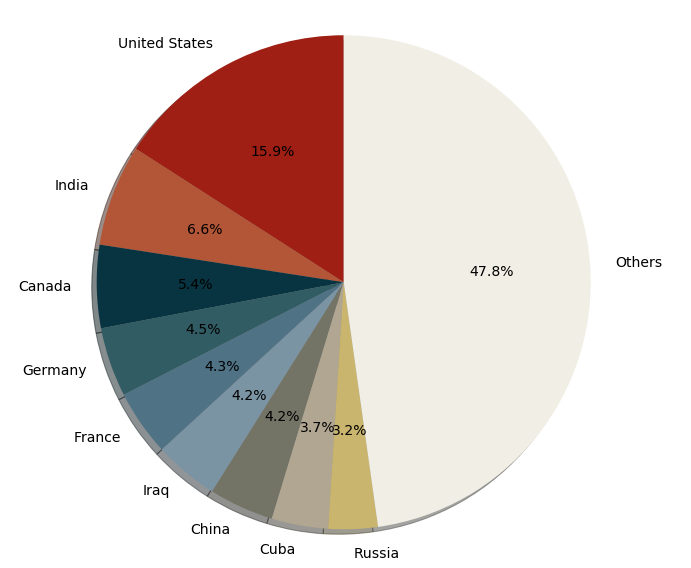

In [48]:
matplotlib.rcParams['figure.figsize'] = (12.0,10.0)
import matplotlib as mpl
mpl.rcParams['font.size'] = 14.0
dfV = pd.DataFrame(sorted_paises)
dfV.columns = ['country', 'times']
dfV.loc[9, 'country'] ='Others'
dfV.loc[9, 'times'] = dfV[9:].times.sum()
dfV = dfV[:10]


labels = dfV['country'].values
sizes = dfV['times'].values
explode = (0, 0, 0, 0, 0, 0, 0,0,0,0) 

fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        colors=["#9F1F15", "#B35637", "#083441", "#325C63", "#4F7285", "#7A94A4", "#737466", "#B1A691", "#C9B56E", "#F1EFE5"], shadow=True, startangle=90)

ax1.axis('equal')  

plt.savefig('imgs/Figure7.png', dpi=100, bbox_inches = 'tight')

## Paises relacionados

In [22]:
import csv
sorted_relations = sorted(relations.items(), key=operator.itemgetter(1), reverse = True)
file = open('data/related_countries.csv', "w")
file_writer = csv.writer(file, delimiter='\t')
header = ["id", "p1", "p2", "w"]
file_writer.writerow(header) 
for i, t in enumerate(sorted_relations):
    p1 = t[0].split('-')[0]
    p2 = t[0].split('-')[1]
    weigth = t[1]
    file_writer.writerow([i,p1,p2,weigth]) 
file.close()

## Over time

In [46]:
dict_paises = {}
with open('data/affiliations_country_geo.csv', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        if(row[0]=='country'):
            continue
        dict_paises[row[0]] = [row[2], row[3]]
dict_paises['Iraq'] = [33.223191, 43.679291]
dict_paises['Sierra Leone'] = [8.460555, -11.779889]
dict_paises['Nigeria'] = [9.081999, 8.675277]
dict_paises['Niger'] = [9.081999, 8.675277]
otro = {'Afghanistan': [33.93911, 67.709953],
 'Antarctica': [-82.862752, 135],
 'Armenia': [40.069099, 45.038189],
 'Belarus': [53.709807, 27.953389],
 'Bermuda': [32.3078, -64.7505],
 'Botswana': [-22.328474, 24.684866],
 'Brunei Darussalam': [4.535277, 114.727669],
 'Cameroon': [7.369721999999999, 12.354722],
 'Cape Verde': [16.5388, -23.0418],
 'Congo': [-4.038333, 21.758664],
 'Dominican Republic': [18.735693, -70.162651],
 'Ecuador': [-1.831239, -78.18340599999999],
 'Egypt': [26.820553, 30.802498],
 'El Salvador': [13.794185, -88.89653],
 'Ethiopia': [9.145000000000001, 40.489673],
 'French Guiana': [3.933889, -53.125782],
 'Gambia': [13.443182, -15.310139],
 'Gibraltar': [36.140751, -5.353585],
 'Greenland': [71.706936, -42.604303],
 'Guadeloupe': [16.265, -61.55099999999999],
 'Guatemala': [15.783471, -90.23075899999999],
 'Guinea': [9.945587, -9.696645],
 'Guinea-Bissau': [11.803749, -15.180413],
 'Guyana': [4.860416, -58.93018],
 'Haiti': [18.971187, -72.285215],
 'Hong Kong': [22.396428, 114.109497],
 'Iceland': [64.963051, -19.020835],
 'Jersey': [49.214439, -2.13125],
 'Latvia': [56.879635, 24.603189],
 'Lebanon': [33.854721, 35.862285],
 'Liberia': [6.428055, -9.429499000000002],
 'Martinique': [14.641528, -61.024174],
 'Mongolia': [46.862496, 103.846656],
 'Montserrat': [16.742498, -62.187366],
 'Mozambique': [-18.665695, 35.529562],
 'Namibia': [-22.95764, 18.49041],
 'Nicaragua': [12.865416, -85.207229],
 'North Korea': [40.339852, 127.510093],
 'Pakistan': [30.375321, 69.34511599999999],
 'Panama': [8.537981, -80.782127],
 'Philippines': [12.879721, 121.774017],
 'Pitcairn': [-24.3767537, -128.3242376],
 'Solomon Islands': [-9.64571, 160.156194],
 'Somalia': [5.152149, 46.199616],
 'Sri Lanka': [7.873053999999999, 80.77179699999999],
 'Sudan': [12.862807, 30.217636],
 'Togo': [8.619543, 0.824782],
 'Tunisia': [33.886917, 9.537499],
 'Uganda': [1.373333, 32.290275],
 'Ukraine': [48.379433, 31.1655799],
 'Uruguay': [-32.522779, -55.765835], 
 'Puerto Rico': [18.220833, -66.590149]}
for k in otro:
    dict_paises[k] = otro[k]

relations_time = []
i=0
for idx, row in df.iterrows():
    try:

        abstract = row['abstract']
        if type(abstract) == float:
            continue
        rel = []
        for k in countries.keys():
            ck = abstract.count(k)
            cv = abstract.count(countries[k])
            if ck + cv > 0:
                if k not in paises.keys():
                    paises[k] = 0
                paises[k]  = paises[k] + ck + cv 
                rel.append(k)
        for r in rel:
            for r2 in rel:
                  if r != r2:
                    relations_time.append([i, r, r2, row['year'], dict_paises[r][0],dict_paises[r][1],dict_paises[r2][0],dict_paises[r2][1]])
                    i +=1
    except Exception as e:

'Mali'
'Kenya'
'Libyan Arab Jamahiriya'
'Yemen'
'Thailand'
'Benin'
'Benin'
'Mali'
'Saudi Arabia'
'Tanzania, United Republic of'
'Comoros'
'Cambodia'
'Mali'
'Mali'
'Saudi Arabia'
'Saudi Arabia'
'Montenegro'
'Saudi Arabia'
'Cambodia'
'Bangladesh'
'Malta'
'Indonesia'
'Kenya'
'Saudi Arabia'
'Saudi Arabia'
'Tanzania, United Republic of'
'Madagascar'
'French Polynesia'
6533


In [50]:
spanish = [
 'Bermuda',
 'Cameroon',
 'Cape Verde',
 'Congo',
 'Dominican Republic',
 'Ecuador',
 'El Salvador',
 'Gibraltar',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Nicaragua',
 'Panama',
 'Uruguay',
 'Puerto Rico', 
'United States',
'United Kingdom',
'Canada',
'Germany',
'France',
'Italy',
'Spain',
'Austria',
'South Africa',
'Brazil',
'India',
'Russia',
'Portugal',
'Mexico',
'Argentina',
'Chile',
'Colombia',
'Iran',
'Dominica',
'Peru',
'Cuba',
'Bolivia',
'Trinidad and Tobago',
'Bahamas',
'Barbados',
'México',
'Costa Rica',
'Jamaica',
'Venezuela, Bolivarian Republic of']

file = open('data/related_countries_over_time.csv', "w")
file_writer = csv.writer(file, delimiter='\t')
header = ["id", "p1", "p2", "year", "p1_lat", "p1_long", "p2_lat", "p2_long"]
file_writer.writerow(header) 
for r in relations_time:
    if(r[1] in spanish and r[2] in spanish):
        file_writer.writerow(r)
    

## Paises hablan de Paises

In [54]:
sorted_aff = sorted(affiliations_paises.items(), key=operator.itemgetter(1), reverse = True)
sorted_aff

[('University London->United States', 18),
 ('Johns Hopkins University->United States', 11),
 ('Georgetown University->United States', 10),
 ('University of California->United States', 9),
 ('University of Toronto->Canada', 8),
 ('New York University->United States', 8),
 ('University London->Jamaica', 7),
 ('University London->France', 6),
 ('Harvard University->France', 6),
 ('Queens University Belfast->United States', 6),
 ('Columbia University->United States', 6),
 ('University London->Iraq', 6),
 ('Harvard University->United States', 6),
 ('Brown University->Spain', 6),
 ('University of Ottawa->Canada', 6),
 ('Kadir Has University->Turkey', 5),
 ('Queens University->Ireland', 5),
 ('Yale University->United States', 5),
 ('University Edinburgh->United States', 5),
 ('East Stroudsburg University->United States', 5),
 ('Vanderbilt University->United States', 5),
 ('University Toronto->Canada', 5),
 ('Free University Berlin->United States', 5),
 ('State University of New York->United 